### Calculate 95% limit with Bayesian method with a flat prior
Marginalize the likelihood via MC integration.
Then interpret the marginalized likelihood as a posterior pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.stats import norm
import math

# Using the lognormal from numba_stats
# unstead of scipy_stats speeds things
# up by a big factor.
# Be careful however because the call sequences
# are not exactly the sameand not all
# functions are implemented.
# from scipy.stats import lognorm
from numba_stats import lognorm

### This is fake data with 3 point

In [2]:
# This is some fake data in 3 bins
data = np.array([ 7,  6, 1])  # observed
sig  = np.array([ 2,  2, 2])  # signal predicted with mu=1
bg   = np.array([10,  5, 2])  # bg predicted
err  = 0.2*bg                 # bg uncertainty

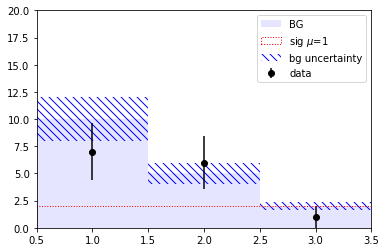

In [3]:
# plot it
x = np.array([1.,2.,3.])
b = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
ax = plt.subplot(111)
ax.hist(x, b, weights=bg,  alpha=0.1, color='blue', label='BG', histtype='stepfilled')

n1,b1,p1 = ax.hist(x, b, weights=bg+err, histtype='stepfilled',
                   facecolor='none', edgecolor='none', linestyle='--')
n2,b2,p2 = ax.hist(x, b, weights=bg-err, histtype='stepfilled', 
                   facecolor='none', edgecolor='none', linestyle='--')
ax.bar(x=b1[:-1], height=n2-n1, bottom=n1, width=np.diff(b1),
       align='edge', linewidth=0, edgecolor='blue', color='none', zorder=-1, 
       label='bg uncertainty', hatch='\\\\\\')

ax.hist(x, b, weights=sig, color='red', label='sig $\mu$=1', histtype='step',
        linestyle='dotted')
ax.errorbar(x, data, yerr=np.sqrt(data), fmt='o', color='black', label='data')
# ax.bar(x, sig, align='center',width=1, color='None', edgecolor='red', label='sig ($\mu$=1)')

ax.set_xlim((0.5, 3.5))
ax.legend()
_ = ax.set_ylim((0,20))

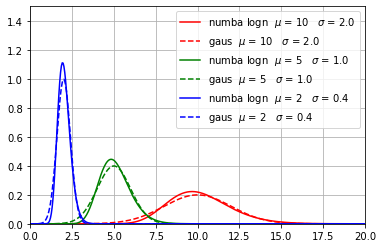

In [4]:
# check that lognormal makese sense, compare with gaussian
color = ('red', 'green', 'blue')
ax21=plt.subplot(111)
for b,e,c in zip(bg, err, color):
    x = np.linspace(0.01, 20., 400)
    ax21.plot(x, lognorm.pdf(x, np.log(1+e/b), 0, b), color=c, 
            label='numba logn  $\mu$ = '+str(b) + '   $\sigma$ = ' + str(e))
    ax21.plot(x, norm.pdf(x,    scale=e, loc=b), color=c, linestyle='dashed', 
            label='gaus  $\mu$ = '+str(b) + '   $\sigma$ = ' + str(e))

ax21.grid()
ax21.legend()
ax21.set_xlim([0, 20.])
_ = ax21.set_ylim(0,1.5)

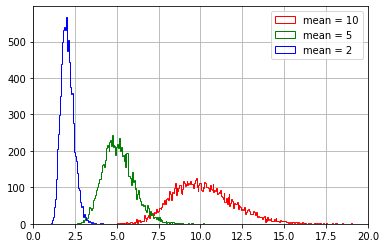

In [5]:
# make sure that we know how to pick according to lognormal
np.random.seed(12345)
picks  = []
nPicks = 10000
for b,e in zip(bg, err):
    temp = np.random.lognormal(np.log(b), np.log(1+e/b), nPicks)
    picks.append(temp)
    
for b,e,y,c in zip(bg, err, picks, color):
    x = np.linspace(0.0, 20., 400)
    ax22=plt.subplot(111)
    _ = ax22.hist(y, x, histtype='step', color=c, label="mean = "+str(b))

ax22.grid()
ax22.legend()
_ = ax22.set_xlim([0, 20.])

In [6]:
# calculate likelihood function for given mu,b,s,counts. (ignore the constant factorials)
def getlik(mu, counts, s, b):
    totalExpected  = mu*s+b
    temp = 1.
    for n,t in zip(counts, totalExpected):
        temp = temp * (t**n) 
    return temp*math.exp(-totalExpected.sum())

In [7]:
# scan mu, marginalize at a given mu
b0     = np.array(picks[0])   # ugly but works
b1     = np.array(picks[1])
b2     = np.array(picks[2])
nMu    = 501
muScan = np.linspace(0,5.,nMu)
lik    = np.empty(nMu)
for i in range(nMu):
    m          = muScan[i]
    if i%20 == 0:
        print(m)
    sumLik = 0.
    for bb0,bb1,bb2 in zip(b0, b1, b2):
        sumLik = sumLik + getlik(m, data, sig, np.array([bb0, bb1, bb2]))
        # print(sumLik)
    lik[i] = sumLik/len(b0)
    

0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0
2.2
2.4
2.6
2.8000000000000003
3.0
3.2
3.4
3.6
3.8000000000000003
4.0
4.2
4.4
4.6000000000000005
4.8
5.0


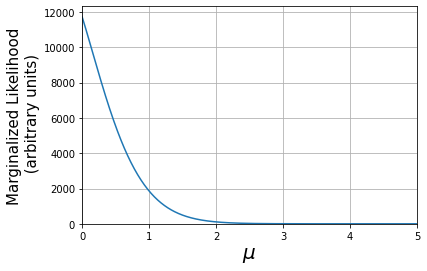

In [8]:
# Plot the merginalized likelihhod
ax33 = plt.subplot(111)
ax33.plot(muScan, lik)
ax33.set_xlabel('$\mu$', size=20)
ax33.set_ylabel('Marginalized Likelihood\n (arbitrary units)', size=15)
ax33.set_ylim(bottom=0)
ax33.set_xlim(muScan[0],muScan[-1])
ax33.grid()

In [9]:
# find the 95% point
# i is the index of the first element past the 95% point
cumlik = np.cumsum(lik)/lik.sum()
i = np.nonzero(cumlik>0.95)[0][0]
# do some interpolation
dlik = (0.95-cumlik[i-1]) / (cumlik[i] - cumlik[i-1])
dmu  = muScan[i] - muScan[i-1]
mu95 = muScan[i-1] + dlik*dmu
print(muScan[i-1], mu95, muScan[i])
print(cumlik[i-1], cumlik[i])

1.24 1.2464608820756984 1.25
0.9490595948215217 0.9505151316467726


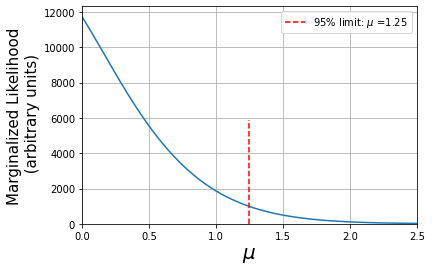

In [10]:
# now plot it again but zoom in a little bit
ax34 = plt.subplot(111)
ax34.plot(muScan, lik)
ax34.set_xlabel('$\mu$', size=20)
ax34.set_ylabel('Marginalized Likelihood\n (arbitrary units)', size=15)
ax34.set_ylim(bottom=0)
ax34.set_xlim(muScan[0],2.5)
ax34.plot([mu95, mu95], [0, 0.5*np.amax(lik)], color='red', linestyle='dashed',
         label='95% limit: $\mu$ ='+str(round(mu95,2)))
ax34.grid()
_ = ax34.legend()